# Would online doctors work? -Investigate allocation and performance of telehealth by OR methods.
## Summer Undergraduate Research Fellowship of XJTLU

Author: Mengyuan Xu, Qi Huang, Shiyao Gu, Xintian Chen, Xiaoman Dai, Zixuan Xu

Supervisor: Ruonan Zhang

## Catalogue:
In the first four steps, we will construct the models for our two types of consultation modes based on all the assumptions. Then, in the last two steps, we will test the models and conduct a sensitivity analysis. Additionally, we have provided a user guide for the code.
- [Step1](#step-01-patient-arrival-model)
Patient arrival model
- [Step2](#step-02-all-other-parameters)
All other parameters
- [Step3](#step-03-further-data-processing)
Further data processing
- [Step4](#step-04-construction-of-the-queuing-model)
Construction of queuing model
- [User manual for this notebook](#user-manual-for-this-notebook)
- [Step5](#step-04-model-analysis-1)
Model analysis 1 (Simulation)
- [Step6](#step-06-model-analysis-2)
Model analysis 2 (Sensitive analysis)

Click to jump to the corresponding step. (This function may not be available for online preview.)

## Step 01: Patient Arrival Model
Here we construct a Patient Arrival Model, randomly generating a set of arrival times. Based on the assumed working hours, which are 8:00 AM to 5:00 PM, we will truncate the data accordingly.

In [1]:
import numpy as np
def generate_patient_arrivals(mean_interarrival_time=10):
    """
    Generate patient arrivals based on an exponential distribution of interarrival times.
    
    Parameters:
    mean_interarrival_time (int): The mean time between arrivals, in minutes.
    total_time (int): The total simulation time, in minutes (default is 720 minutes, equivalent to 12 hours).
    
    Returns:
    arrival_times (numpy array): An array of patient arrival times within the specified total time.
    total_patients (int): The total number of patients arriving within the specified total time.
    """
    
    # Generate interarrival times following an exponential distribution
    interarrival_times = np.random.exponential(scale=mean_interarrival_time, size=10000)
    
    # Calculate the arrival time for each patient
    arrival_times = np.cumsum(interarrival_times)
    
    # Only keep arrival times within the total time of 540 minutes
    arrival_times = arrival_times[arrival_times <= 540]
    
    # Round the arrival times to the nearest integer
    arrival_times = np.round(arrival_times).astype(int)
    
    # Calculate the total number of patients
    total_patients = len(arrival_times)
    
    return arrival_times, total_patients

Below, we will conduct a simple test of this program:

In [2]:
arrival_times_test, total_patients_test = generate_patient_arrivals()
print("Patient Arrival Times Vector:", arrival_times_test)
print("Total Number of Patients:", total_patients_test)

Patient Arrival Times Vector: [  2   5   5   8  15  22  27  30  33  36  42  43  50  58  74  76  78  80
  80 100 121 124 126 138 145 159 176 203 212 230 232 236 249 281 303 306
 321 325 329 341 352 362 368 380 382 403 415 433 446 453 459 467 476 482
 489 493 498 499 502 502 508 516 531]
Total Number of Patients: 63


To improve the readability of this code, the following method converts the data into the HH:MM time format.

In [3]:
def time_from_minutes(minutes_vector):
    """
    Convert a vector of minutes from 8:00 into a vector of times in HH:MM format.
    
    Parameters:
    minutes_vector (np.ndarray): A NumPy array containing integers representing the minutes passed since 8:00.
    
    Returns:
    np.ndarray: A NumPy array containing strings in HH:MM format representing the current time.
    """
    base_hour = 8
    base_minute = 0
    
    def convert_minutes_to_time(minutes):
        total_minutes = base_hour * 60 + base_minute + minutes
        hours = (total_minutes // 60) % 24
        minutes = total_minutes % 60
        return f"{hours:02}:{minutes:02}"
    
    time_vector = np.vectorize(convert_minutes_to_time)(minutes_vector)
    return time_vector

Then we do a quick test:

In [4]:
arrival_times_modified = time_from_minutes(arrival_times_test)
print("Patient Arrival Times Vector:", arrival_times_modified)

Patient Arrival Times Vector: ['08:02' '08:05' '08:05' '08:08' '08:15' '08:22' '08:27' '08:30' '08:33'
 '08:36' '08:42' '08:43' '08:50' '08:58' '09:14' '09:16' '09:18' '09:20'
 '09:20' '09:40' '10:01' '10:04' '10:06' '10:18' '10:25' '10:39' '10:56'
 '11:23' '11:32' '11:50' '11:52' '11:56' '12:09' '12:41' '13:03' '13:06'
 '13:21' '13:25' '13:29' '13:41' '13:52' '14:02' '14:08' '14:20' '14:22'
 '14:43' '14:55' '15:13' '15:26' '15:33' '15:39' '15:47' '15:56' '16:02'
 '16:09' '16:13' '16:18' '16:19' '16:22' '16:22' '16:28' '16:36' '16:51']


## Step 02: All other parameters

Here we list all other parameters we need: 

1. Time spent in Reception or Precheck
2. Scores of PHQ-9
3. Scores of GAD-7
4. Time to the offline
5. Transition to in-person? (Effective only for data where both PHQ and GAD scores are less than 10. For others that were initially in-person, mark as `TRUE`.)
6. Diagnosis Time (related to PHQ and GAD, as shown in the table below:)

(Sum PHQ and GAD to get score range)

| Score range | Period(min) |
|-------------|-------------|
| 0-8         | 1-15        |
| 9-18        | 15-25       |
| 19-28       | 25-35       |
| 29-38       | 35-45       |
| >39         | 45-60       |

For that the last two parameters are based on the first four parameters, we first give codes to generate data of parameter 1234. 

- Time spent in Reception or Precheck

In [5]:
import random

def generate_time_spent_in_precheck(n):
    """
    Generate a list of time_spent_in_precheck values.

    Each value in the list follows a uniform distribution between 5 and 10.

    Parameters:
    n (int): The number of values to generate.

    Returns:
    list: A list of n values where each value is a float between 5 and 10.
    """
    # Initialize an empty list to store the generated values
    time_spent_in_precheck = []
    
    # Loop n times to generate n values
    for _ in range(n):
        # Generate a random float value between 5 and 10
        value = random.uniform(5, 10)
        # Append the generated value to the list
        time_spent_in_precheck.append(value)
    
    # Round to the nearest integer
    time_spent_in_precheck = np.round(time_spent_in_precheck).astype(int)
    # Return the list of generated values
    return time_spent_in_precheck

Then we do a quick test: 

In [6]:
test_result1 = generate_time_spent_in_precheck(10)
print(test_result1)

[ 7  9  8  6  7  6 10  6  9  9]


- Time to the offline

In [7]:
def generate_time_to_offline():
    """
    Generate a random time to offline value within the range 10 to 540.

    Returns:
    int: A random integer within the range 10 to 540.
    """
    return int(random.uniform(10, 540))

- Scores of PHQ-9 and GAD-7

Here, we assume that the measure of depression(both PHQ and GAD) follows a normal distribution. This way, we can generate data for different categories of people by adjusting the mean and variance.

In [8]:
def generate_depression_scores(n, mu, sigma_squared,lower_bound,upper_bound):
    """
    Generate a list of depression index scores.

    Each score follows a normal distribution with the specified mean and variance,
    and is constrained within the range of 0 to 49.

    Parameters:
    n (int): The number of scores to generate.
    mu (float): The mean of the normal distribution.
    sigma_squared (float): The variance of the normal distribution.

    Returns:
    list: A list of n scores where each score is a float between 0 and 49.
    """
    # Calculate the standard deviation from the variance
    sigma = sigma_squared ** 0.5
    
    # Initialize an empty list to store the generated scores
    depression_scores = []
    
    # Loop n times to generate n scores
    for _ in range(n):
        # Generate a random score from the normal distribution
        score = random.gauss(mu, sigma)
        # Constrain the score within the range of 0 to 49
        if score < lower_bound:
            score = lower_bound
        elif score > upper_bound:
            score = upper_bound
        # Append the constrained score to the list
        depression_scores.append(score)
    
    # Round to the nearest integer
    depression_scores= np.round(depression_scores).astype(int)
    # Return the list of generated scores
    return depression_scores

Then we do a quick test on it.

In [9]:
test_result2 = generate_depression_scores(10, 8, 50, 0, 27)
print(test_result2)
test_result3 = generate_depression_scores(10, 8, 50, 0, 21)
print(test_result3)

[ 4  0 12  0  5 17  8  0  6 10]
[ 8 16  4 21  5 18  8 12 10  9]


Before moving on to the next step, we design a method to map the sum of PHQ and GAD scores to the diagnosis time.

In [10]:
def map_scores_to_periods(scores):
    """
    Map each depression index score to a corresponding period based on the given table.

    Parameters:
    scores (list): A list of depression index scores.

    Returns:
    list: A list of random values within the corresponding periods for each score.
    """
    # Define the mapping from score ranges to periods
    score_to_period = [
        (0, 8, 1, 15),
        (9, 18, 15, 25),
        (19, 28, 25, 35),
        (29, 38, 35, 45),
        (39, 49, 45, 60)
    ]
    
    # Initialize an empty list to store the mapped periods
    periods = []
    
    # Loop through each score in the input list
    for score in scores:
        # Find the corresponding period range for the score
        for min_score, max_score, min_period, max_period in score_to_period:
            if min_score <= score <= max_score:
                # Generate a random value within the period range
                period = random.uniform(min_period, max_period)
                periods.append(period)
                break
    
    # Round to the nearest integer
    periods= np.round(periods).astype(int)
    # Return the list of mapped periods
    return periods


Then we do a quick test: 

In [11]:
test_scores = [5, 10, 20, 30, 40]
test_result4 = map_scores_to_periods(test_scores)
print(test_result4)

[ 7 20 28 42 57]


## Step 03: Further data processing

Now we will organize the above data into a matrix in this way:

|Person 1     | Person 2    | ......      | 
|-------------|-------------|-------------|
| Arrival time 1 | Arrival time 2 | ...... |
| Time in Reception/Pre-check1      | Time in Reception/Pre-check2      |...... |
| Score PHQ 1      | Score PHQ 2      |......|
| Score GAD 1      | Score GAD 2     |......|


In [12]:
def generate_a_data_matrix(mean=20, mu=8, var=50):
    """
    This function generates a data matrix for patient information in a medical study.
    It includes the following steps:
    1. Generate the arrival times of the patients and the total number of patients.
    2. Generate the time each patient spends in precheck.
    3. Generate PHQ (Patient Health Questionnaire) depression scores for each patient.
    4. Generate GAD (Generalized Anxiety Disorder) scores for each patient.
    5. Stack the generated data into a matrix and return it.

    Returns:
        numpy.ndarray: A 2D array where each row corresponds to a different type of data:
                       - Arrival times
                       - Time spent in precheck
                       - PHQ scores
                       - GAD scores
    """
    arrival_times, total_patients = generate_patient_arrivals(mean)
    time_in_precheck = generate_time_spent_in_precheck(total_patients)
    PHQ = generate_depression_scores(total_patients, mu, var, 0, 27)
    GAD = generate_depression_scores(total_patients, mu, var, 0, 21)
    
    return np.vstack((arrival_times, time_in_precheck, PHQ, GAD))

Then we do a quick test

In [13]:
print(generate_a_data_matrix())

[[ 32  57  80  89 102 124 153 167 200 244 264 282 286 305 327 342 342 379
  398 417 429 443 450 470 483 487 503 523 532 538]
 [ 10  10   8   9   9   8   9   8   6   9   5   9   8   6  10   8   7   5
    9   6   8   8   9   7   5   8  10   7   9  10]
 [  1   5   0  11  12   5   0   6   4  17   5   0   0   2   8  13  10  10
   11   3  14  11   0   7  17   7   6  18   0   4]
 [  4  16  19  19  11   4  11   7  21  10   1   6   0   0  14  21   4  13
   10   0   1   5  11   0   2  10  14  15   7   2]]


Now, we will try to simulate the situation of transitioning to offline. The approach is as follows:

1.	We consider the people transitioning to offline as new patients. However, since they must directly go through offline channels to enter the system, we assign them a mandatory offline tag.
2.	Now, for programming purposes, we understand the condition for this mandatory offline tag: it is possible to obtain the mandatory offline tag if both indicators are below 10.
3.	For general patients, they do not have the mandatory offline tag.
4.	If they have the mandatory offline tag, it is marked as `True`. If not, it is marked as `False`.

In [14]:
def add_mandatory_offline_tag(matrix, n):
    """
    Add a mandatory offline tag to the given matrix.

    If the values in the third and fourth rows are both less than 10, 
    add a fifth row with a True value with a probability of n, otherwise False.

    Parameters:
    matrix (numpy.ndarray): A 4xN matrix of integers.
    n (float): The probability of adding True if the condition is met.

    Returns:
    numpy.ndarray: The modified matrix with an added fifth row.
    """
    
    # Initialize an empty list to store the fifth row values
    mandatory_offline_tag = []
    
    # Loop through each column in the matrix
    for i in range(matrix.shape[1]):
        # Get the values from the third and fourth rows
        third_row_value = matrix[2, i]
        fourth_row_value = matrix[3, i]
        
        # Check if both values are less than 10
        if third_row_value < 10 and fourth_row_value < 10:
            # Add True with a probability of n, otherwise False
            tag = np.random.rand() < n
        else:
            # Add False if the condition is not met
            tag = False
        
        # Append the tag to the list
        mandatory_offline_tag.append(tag)
    
    # Convert the list to a numpy array and reshape to a row vector
    mandatory_offline_tag = np.array(mandatory_offline_tag).reshape(1, -1)
    
    # Append the fifth row to the input matrix
    modified_matrix = np.vstack((matrix, mandatory_offline_tag))
    
    return modified_matrix

Then we do a quick test: 

In [15]:
print(add_mandatory_offline_tag(generate_a_data_matrix(),0.2))

[[  5  15  88 135 166 184 234 348 387 411 425 432 444 449 494 495 538]
 [  5   8   7   7   6   7   6   7   9   7   6  10   6   8   8   9   7]
 [  8   0  11   3   7  12   0  12  10  10   5  16  16  12   6   6   3]
 [ 16   5   0   8   0  18  18   5   0  15   1   3  14   6   5   8  16]
 [  0   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0   0]]


Now, based on the above results, we will update the matrix, keeping only the times when patients visit the clinic.

In [16]:
def update_matrix_with_offline_times(matrix):
    """
    Update the given matrix by adding a time to offline value to the first row 
    if the corresponding column in the last row is marked as True.

    Parameters:
    matrix (numpy.ndarray): A 5xN matrix where the last row contains True/False values.

    Returns:
    numpy.ndarray: The modified matrix with updated values in the first row.
    """
    # Check if the input matrix has 5 rows
    if matrix.shape[0] != 5:
        raise ValueError("The input matrix must have 5 rows.")
    
    # Loop through each column in the matrix
    for i in range(matrix.shape[1]):
        # Check if the last row in the current column is True
        if matrix[4, i]:
            # Generate a random time to offline value
            time_to_offline_value = generate_time_to_offline()
            # Add the generated value to the first row of the current column
            matrix[0, i] += time_to_offline_value
    
    return matrix

Then we do a quick test:

In [17]:
print(update_matrix_with_offline_times(add_mandatory_offline_tag(generate_a_data_matrix(), 0.2)))

[[  6  56  97  99 110 134 136 140 154 161 244 250 253 273 273 291 300 305
  345 378 416 454 479 481 503 508]
 [  8   6  10   9   8   8   8   6   6   6   9   6   6   9   6   7   7   8
    9  10  10   7   8   7   9   8]
 [  4  23  24  18  18  12   8  11   0   7   0   5   0   4  16   2   6   7
    8   6   1  19   3  18  12  16]
 [ 16   5   9  15   3   6  16  14   4  15  12   5  15  19  14   8   6  15
   14   2   6   6   6   0  13   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]


The final step is to remove all patients who meet the conditions for online consultations, unless the patient has a mandatory offline tag.

In [18]:
def remove_online_patients(matrix):
    """
    Delete columns from the matrix where:
    1. Both values in the third and fourth rows are less than 10.
    2. The value in the last row (fifth row) is False.

    Parameters:
    matrix (numpy.ndarray): A 5xN matrix.

    Returns:
    numpy.ndarray: The modified matrix with columns deleted based on the conditions.
    """
    # Check if the input matrix has 5 rows
    if matrix.shape[0] != 5:
        raise ValueError("The input matrix must have 5 rows.")
    
    # Initialize a list to keep track of columns to keep
    columns_to_keep = []
    
    # Loop through each column in the matrix
    for i in range(matrix.shape[1]):
        # Get the values from the third and fourth rows
        third_row_value = matrix[2, i]
        fourth_row_value = matrix[3, i]
        # Get the value from the last row
        last_row_value = matrix[4, i]
        
        # Check the conditions for keeping the column
        if not (third_row_value < 10 and fourth_row_value < 10 and last_row_value == False):
            columns_to_keep.append(i)
    
    # Create a new matrix with only the columns to keep
    modified_matrix = matrix[:, columns_to_keep]
    
    return modified_matrix

In [19]:
test_data = update_matrix_with_offline_times(add_mandatory_offline_tag(generate_a_data_matrix(), 0.2))
print(test_data)
test_data2 = remove_online_patients(test_data)
print(test_data2)

[[ 20  39  47  50  67  88 100 101 120 148 162 166 169 180 187 203 211 211
  256 429 302 311 312 324 351 359 383 396 461 505 521 521]
 [  9   8   5   5   9   9  10   8   5   9   9   9   8   9   6   7   7   7
    6   7   8   6   7   7   6   7   7   9   9   8   6   9]
 [ 11   2   6  10  13   6   1   6  11  11  15   9  17   8   9  11  13   0
    0   0  14   4  24  17  12  10  14  14  10   6  17   6]
 [  8   9   0   0  15  18  16   6  21  13   7  12  12  19  17   7  12  21
   11   8   1   5   9   1  12   8   4   5   8   5   0   4]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0   0   0   0   0]]
[[ 20  50  67  88 100 120 148 162 166 169 180 187 203 211 211 256 429 302
  312 324 351 359 383 396 461 521]
 [  9   5   9   9  10   5   9   9   9   8   9   6   7   7   7   6   7   8
    7   7   6   7   7   9   9   6]
 [ 11  10  13   6   1  11  11  15   9  17   8   9  11  13   0   0   0  14
   24  17  12  10  14  14  10  17]
 [  8  

Then we do not need the tag any more.

In [20]:
def remove_last_row(matrix):
    """
    Remove the last row from the given matrix.

    Parameters:
    matrix (numpy.ndarray): An MxN matrix.

    Returns:
    numpy.ndarray: The modified matrix with the last row removed.
    """
    # Check if the matrix has more than one row
    if matrix.shape[0] < 2:
        raise ValueError("The matrix must have at least two rows to remove the last one.")
    
    # Remove the last row using numpy slicing
    modified_matrix = matrix[:-1, :]
    
    return modified_matrix

Then we do a quick test:

In [21]:
test_data3 = remove_last_row(test_data2)
print(test_data3)

[[ 20  50  67  88 100 120 148 162 166 169 180 187 203 211 211 256 429 302
  312 324 351 359 383 396 461 521]
 [  9   5   9   9  10   5   9   9   9   8   9   6   7   7   7   6   7   8
    7   7   6   7   7   9   9   6]
 [ 11  10  13   6   1  11  11  15   9  17   8   9  11  13   0   0   0  14
   24  17  12  10  14  14  10  17]
 [  8   0  15  18  16  21  13   7  12  12  19  17   7  12  21  11   8   1
    9   1  12   8   4   5   8   0]]


Now, we will sort the arrival times again in ascending order and remove items greater than 540.

In [22]:
def remove_columns_and_sort(matrix):
    """
    Remove columns from the matrix where the first row has values greater than 540,
    then sort the matrix based on the first row in ascending order.

    Parameters:
    matrix (numpy.ndarray): An MxN matrix.

    Returns:
    numpy.ndarray: The modified matrix with columns removed and sorted.
    """
    # Remove columns where the first row has values greater than 540
    filtered_matrix = matrix[:, matrix[0, :] <= 540]
    
    # Sort the matrix based on the first row
    sorted_indices = np.argsort(filtered_matrix[0, :])
    sorted_matrix = filtered_matrix[:, sorted_indices]
    
    return sorted_matrix

Then we do quick test: 

In [23]:
test_data4 = remove_columns_and_sort(test_data3)
print(test_data3)
print(test_data4)

[[ 20  50  67  88 100 120 148 162 166 169 180 187 203 211 211 256 429 302
  312 324 351 359 383 396 461 521]
 [  9   5   9   9  10   5   9   9   9   8   9   6   7   7   7   6   7   8
    7   7   6   7   7   9   9   6]
 [ 11  10  13   6   1  11  11  15   9  17   8   9  11  13   0   0   0  14
   24  17  12  10  14  14  10  17]
 [  8   0  15  18  16  21  13   7  12  12  19  17   7  12  21  11   8   1
    9   1  12   8   4   5   8   0]]
[[ 20  50  67  88 100 120 148 162 166 169 180 187 203 211 211 256 302 312
  324 351 359 383 396 429 461 521]
 [  9   5   9   9  10   5   9   9   9   8   9   6   7   7   7   6   8   7
    7   6   7   7   9   7   9   6]
 [ 11  10  13   6   1  11  11  15   9  17   8   9  11  13   0   0  14  24
   17  12  10  14  14   0  10  17]
 [  8   0  15  18  16  21  13   7  12  12  19  17   7  12  21  11   1   9
    1  12   8   4   5   8   8   0]]


Finally, we use a comprehensive method to integrate all the above methods.

In [24]:
def convert_to_offline_patient_data(data0,n):
    """
    This function generates and processes a data matrix for offline patients in a medical study.
    The steps include:
    1. Generate the initial data matrix for patients.
    2. Add a mandatory offline tag to the data matrix.
    3. Update the matrix with offline times for patients.
    4. Remove data for online patients from the matrix.
    5. Remove the last row of the matrix.
    6. Remove specific columns and sort the matrix.

    Parameters:
        n (int): The number of patients to process for offline tagging.

    Returns:
        numpy.ndarray: A processed 2D array for offline patients with specified transformations applied.
    """
    data1 = add_mandatory_offline_tag(data0, n)
    data2 = update_matrix_with_offline_times(data1)
    data3 = remove_online_patients(data2)
    data4 = remove_last_row(data3)
    data5 = remove_columns_and_sort(data4)

    return data5

Finnally we do a quick test to finish this step.

In [25]:
final_test_data = generate_a_data_matrix()
print(final_test_data)
print(convert_to_offline_patient_data(final_test_data,0.2))

[[ 20  58  68  87 105 123 140 141 174 190 199 205 223 246 267 281 317 338
  339 347 352 388 402 447 447 463 464 478]
 [  6   8   8   8   9   9   7   8   6   5   6   9   6  10   6   7   9   7
    5   7   8   5   6   8   9   7   9   6]
 [  0   8  11  16   8   4   4   0   2   9   0   7   3   5  10   0   8  20
   21   5  18   0   6  17   0   9   0  19]
 [ 13   1   8   0  21  11   4   0   0  20   0  10   6  10   0  18   8  13
   19  21  21   7   6  11  16   0  16   4]]
[[ 20  68  87 105 123 190 205 246 267 281 336 338 339 347 352 447 447 464
  478]
 [  6   8   8   9   9   5   9  10   6   7   8   7   5   7   8   8   9   9
    6]
 [  0  11  16   8   4   9   7   5  10   0   0  20  21   5  18  17   0   0
   19]
 [ 13   8   0  21  11  20  10  10   0  18   0  13  19  21  21  11  16  16
    4]]


## Step 04: Construction of the Queuing Model

Our previous steps have provided a data matrix structured as shown below.
|Person 1     | Person 2    | ......      | 
|-------------|-------------|-------------|
| Arrival time 1 | Arrival time 2 | ...... |
| Time in Reception/Pre-check1      | Time in Reception/Pre-check2      |...... |
| Score PHQ 1      | Score PHQ 2      |......|
| Score GAD 1      | Score GAD 2     |......|

Regardless of whether it is for a purely offline method or for a method incorporating online consultations, this matrix remains consistent. For the online scenario, the model transitions to offline using the above methods.

To be precise, for a given data matrix(data0): 

- Case 1: Purely offline

Use the quening model directly

- Case 2: With online

Apply `convert_to_offline_patient_data(data0,n)` $\Rightarrow$ Use the quening model

First, we transform the matrix into the following form:
|Person 1     | Person 2    | ......      | 
|-------------|-------------|-------------|
| Arrival time 1 + Time in Reception/Pre-check1    | Arrival time 2 + Time in Reception/Pre-check2  | ...... |
| Diagnosis time 1   | Diagnosis time 2     |......|

In this matrix, the first row of data represents the time patients start waiting, and the second row of data represents the time needed for diagnosis.



In [26]:
def final_transformation(matrix):
    """
    Transform the given matrix as per the specified rules.

    1. Sum the first and second rows to get the first row of the new matrix.
    2. Sum the third and fourth rows and apply map_scores_to_periods method to get the second row of the new matrix.
    3. Sort the matrix based on the first row in ascending order.

    Parameters:
    matrix (numpy.ndarray): An MxN matrix.

    Returns:
    numpy.ndarray: The transformed matrix.
    """
    # Check if the matrix has at least 4 rows
    if matrix.shape[0] < 4:
        raise ValueError("The input matrix must have at least 4 rows.")
    
    # Sum the first and second rows
    first_row = matrix[0, :] + matrix[1, :]
    
    # Sum the third and fourth rows
    summed_scores = matrix[2, :] + matrix[3, :]
    
    # Apply map_scores_to_periods to the summed scores
    second_row = map_scores_to_periods(summed_scores)
    
    # Convert second_row to numpy array for consistency
    second_row = np.array(second_row)
    
    # Combine the new first and second rows into a new matrix
    transformed_matrix = np.vstack((first_row, second_row))
    
    # Sort the matrix based on the first row
    sorted_indices = np.argsort(transformed_matrix[0, :])
    sorted_matrix = transformed_matrix[:, sorted_indices]
    
    return sorted_matrix

Then we do a quick test: 

In [27]:
final_test_data2 = final_transformation(final_test_data)
print(final_test_data2)

[[ 26  66  76  95 114 132 147 149 180 195 205 214 229 256 273 288 326 344
  345 354 360 393 408 455 456 470 473 484]
 [ 16  18  27  23  45  25  10   3  11  44   3  21  18  17  18  21  24  46
   39  27  48   9  21  28  22  22  19  27]]


In [28]:
def queuing_model(matrix):
    """
    Calculate the actual service start times for each patient based on their arrival and service times.

    Parameters:
    matrix (numpy.ndarray): A 2xN matrix where the first row represents arrival times and the second row represents service times.

    Returns:
    numpy.ndarray: A vector representing the actual service start times for each patient.
    """
    # Check if the matrix has exactly 2 rows
    if matrix.shape[0] != 2:
        raise ValueError("The input matrix must have 2 rows.")
    
    # Extract the arrival and service times
    arrival_times = matrix[0, :]
    service_times = matrix[1, :]
    
    # Initialize an array to store the actual service start times
    actual_service_times = np.zeros_like(arrival_times)
    
    # Initialize the time when the next patient can be served
    next_available_time = 0
    
    # Loop through each patient
    for i in range(arrival_times.shape[0]):
        # Calculate the actual service start time for the current patient
        if arrival_times[i] >= next_available_time:
            # If the patient arrives after or when the server is available
            actual_service_times[i] = arrival_times[i]
        else:
            # If the patient arrives before the server is available
            actual_service_times[i] = next_available_time
        
        # Update the next available time
        next_available_time = actual_service_times[i] + service_times[i]
    
    return actual_service_times

Then we do a quick test:

Here we temporarily discard the above test data and regenerate test data to simulate both high and low patient numbers to ensure this step is correct.

In [29]:
low_patient_numbers_test = final_transformation(generate_a_data_matrix(50))
print(low_patient_numbers_test)
print(queuing_model(low_patient_numbers_test))


[[ 71 197 210 242 312 381 390 476 488 505 535]
 [ 30  29  22  19  22  17  20  16  20  18  38]]
[ 71 197 226 248 312 381 398 476 492 512 535]


It looks good! 

Then we do another one.

In [30]:
high_patient_numbers_test = final_transformation(generate_a_data_matrix(10))
print(high_patient_numbers_test)
print(queuing_model(high_patient_numbers_test))

[[ 10  17  23  53  69  79 139 145 146 158 163 167 184 197 198 207 210 218
  223 233 279 281 285 286 295 314 319 323 332 335 353 358 360 361 396 403
  405 408 425 429 429 432 445 458 467 472 478 502 519 544]
 [  3  24  26  35   2  28   3  22  19   4  33  27  24  25  11  35  45  23
   33  16   6  28   9  32  19  19  19  26  19  28  29  30  17  25  21  27
   42   9  17  25  19  13  18   2  16  21  30   5  35  27]]
[  10   17   41   67  102  104  139  145  167  186  190  223  250  274
  299  310  345  390  413  446  462  468  496  505  537  556  575  594
  620  639  667  696  726  743  768  789  816  858  867  884  909  928
  941  959  961  977  998 1028 1033 1068]


It looks good as well! 

Next, we move on to the final step, which is calculating the waiting time.

In [31]:
def calculate_waiting_time(matrix):
    """
    Calculate the average waiting time for patients based on their arrival and service times.

    Parameters:
    matrix (numpy.ndarray): A 2xN matrix where the first row represents arrival times and the second row represents service times.

    Returns:
    float: The average waiting time for patients.
    """
    # Extract the first row as the arrival times vector
    arrival_times = matrix[0, :]
    
    # Apply the queuing_model function to get the actual service start times vector
    service_start_times = queuing_model(matrix)
    
    # Calculate the waiting times by subtracting arrival times from service start times
    waiting_times = service_start_times - arrival_times
    
    # Calculate the total waiting time
    total_waiting_time = np.sum(waiting_times)
    
    # Calculate the average waiting time
    average_waiting_time = total_waiting_time / waiting_times.size
    
    return average_waiting_time

Then we do some quick tests: 

In [32]:
print(calculate_waiting_time(low_patient_numbers_test))
print(calculate_waiting_time(high_patient_numbers_test))

3.727272727272727
253.08


Finally, we will integrate and explain the above code to conclude this step.

In [33]:
def model_to_calculate_average_waiting_time(data):
    """
    This function calculates the average waiting time for patients in a medical study.
    The steps include:
    1. Apply a final transformation to the input data matrix.
    2. Calculate the average waiting time based on the transformed data.

    Parameters:
        data (numpy.ndarray): The input data matrix containing patient information.

    Returns:
        float: The calculated average waiting time for patients. If the input matrix is empty, return 0.
    """
    if data.size == 0:
        return 0.0
    
    data_modified = final_transformation(data)
    average_waiting_time = calculate_waiting_time(data_modified)

    return average_waiting_time

Quick test: 

In [34]:
final_test_data3 = generate_a_data_matrix(30)
print(model_to_calculate_average_waiting_time(final_test_data3))

4.142857142857143


The next step is to analyze the code. Before that, I will provide a user manual for the above code to help with modifications and usage.

## User manual for this notebook
## 代码使用说明书：

This program has three main methods to calculate the average waiting time:

- Method 1: Generate Data

`def generate_a_data_matrix(mean=20, mu=8, var=50):`

In this function, `mean` represents the average patient arrival time, which follows an exponential distribution. You can change this mean value to simulate scenarios with sparser traffic, for instance, by increasing this mean value.

The `mu` and `var` parameters represent the mean and variance of the normal distribution for depression evaluation indices. You can change these mean and variance values to simulate scenarios where the overall severity of patients' depression is more serious, for instance, by increasing the mean.

- Method 2 (for scenarios including offline situations only): Generate Offline Consultation Matrix

`def convert_to_offline_patient_data(data0, n):`

Here, `data0` should be the output value of the preceding method, i.e., the output value of `generate_a_data_matrix`. `n` represents the probability of converting to offline. All model structures are embedded within this method (see the code for specific implementation). This method will return data for patients requiring offline diagnosis to calculate the waiting time.

- Method 3: Queueing Model and Waiting Time Calculation:

`model_to_calculate_average_waiting_time(data)`

Given a patient data matrix, this method will directly return the average waiting time.

A typical procedure to compare the results of two models is as follows:

- Step 1: Generate the data matrix `patient_data = generate_a_data_matrix(mean=20, mu=8, var=50)`

- Step 2: For the online model, generate the offline consultation matrix: `offline_patient_data = convert_to_offline_patient_data(patient_data, 0.5)`

- Step 3: Compare the results of the two models

`print(model_to_calculate_average_waiting_time(patient_data))`
`print(model_to_calculate_average_waiting_time(offline_patient_data))`

本程序为了实现对于平均等待时间的计算，有三个比较主要的方法：
- 方法一：生成数据

`def generate_a_data_matrix(mean=20, mu=8, var=50):`

这里面`mean`表示的是：病人到达时间，指数分布的均值，所以可以改变这个均值，比如将这个均值变大，来模拟客流量更加稀疏的情况。

后面的`mu`,`var`是抑郁症评价指标，所服从的正太分布的均值和方差，可以改变均值和方差，比如将均值增大，来模拟病人总体抑郁情况严重的情况。

- 方法二（仅供包含线上的情况使用）： 生成线下就诊矩阵

`def convert_to_offline_patient_data(data0,n):`

这里的`data0`要作为前序方法的输出值，也就是`generate_a_data_matrix`的输出值。`n`表示转为线下的概率。模型的所有结构内嵌在这个方法内（具体实现方法见代码）。这个方法将返回需要线下诊断的人数据，来计算等待时间。

- 方法三：排队模型和等待时间计算：

`model_to_calculate_average_waiting_time(data)`

给定病人数据矩阵，该方法将直接返回平均等待时间。

对于一个常规的，比较两个模型结果的方法，如下所示：

- 步骤一： 生成数据矩阵`patient_data = generate_a_data_matrix(mean=20, mu=8, var=50)`

- 步骤二： 对于线上模型，生成线下就诊矩阵： `offline_patient_data = convert_to_offline_patient_data(patient_data,0.5)`

- 步骤三： 比较两个模型的结果 

`print(model_to_calculate_average_waiting_time(patient_data))`
`print(model_to_calculate_average_waiting_time(offline_patient_data))`


In [35]:
patient_data = generate_a_data_matrix(mean=20, mu=8, var=50)
offline_patient_data = convert_to_offline_patient_data(patient_data,0.2)
print(model_to_calculate_average_waiting_time(patient_data))
print(model_to_calculate_average_waiting_time(offline_patient_data))

69.37931034482759
23.11764705882353


## Step 05: Model Analysis 1
We divide the entire analysis process into two major steps. In the first major step, we will separately study the impact of incorporating online healthcare in the following four scenarios. In the second major step, we will conduct a more detailed analysis of the model’s sensitivity, including how the model responds to changes in various parameters. More related  explanations will be provided in next step.

Next, we will adjust two parameters to simulate various scenarios:

Parameter 1: The mean of the exponential distribution in the patient arrival model. This parameter represents the clinic’s level of busyness, and we have simulated three values: 15 (busy group), 20 (normal group), and 40 (idle group).
Parameter 2: The mean of the normal distribution for patient questionnaire scores. This parameter represents the level of depression among customers, and we have simulated three values: 3 (minimal depression group), 8 (mild depression group), and 15 (severe depression group).

In other words, after this step is completed, the following table will be filled in.

|level of busyness/level of depression   | busy | normal      | idle|
|-------------|-------------|-------------|-------------|
| minimal depression | G1|G2|G3|
|  mild depression  | G4|G5|G6|
|   severe depression  |G7|G8|G9|


 



Before we begin, we will write a program to simulate the scenario over n days and calculate the average waiting time over those n days. This average waiting time helps to reduce the randomness of the random data and its impact on the analysis results, which will be utilized in the next step.

In [36]:
def simulate_365_days(mean, mu, var, conversion_rate, days=365):
    """
    This function simulates patient data over a period of 365 days (or specified number of days) 
    and calculates the average waiting times for both general and offline patients each day. 
    It then computes the overall average waiting time across all simulated days.

    The steps include:
    1. For each day, generate patient data using specified mean, mu, and variance.
    2. Convert a portion of the patient data to offline patients based on the conversion rate.
    3. Calculate the average waiting time for both the general patient data and the offline patient data.
    4. Store the daily average waiting times.
    5. Calculate the overall average waiting times across all days.

    Parameters:
        mean (float): The mean value used in generating patient data.
        mu (float): A parameter for generating patient data (could represent the rate or a central tendency measure).
        var (float): The variance used in generating patient data.
        conversion_rate (float): The rate at which patients are converted to offline status.
        days (int): The number of days to simulate, default is 365.

    Returns:
        tuple: A tuple containing:
            - overall_avg_waiting_time_patient (float): The overall average waiting time for all patients.(offline only)
            - overall_avg_waiting_time_offline (float): The overall average waiting time for offline patients.(with online)
            - patient_data_waiting_times (list): A list of daily average waiting times for all patients.(offline only)
            - offline_patient_data_waiting_times (list): A list of daily average waiting times for offline patients.(with online)
    """
    # Lists to store average waiting times for each day
    patient_data_waiting_times = []
    offline_patient_data_waiting_times = []
    
    for _ in range(days):
        # Generate patient data for a day
        patient_data = generate_a_data_matrix(mean=mean, mu=mu, var=var)
        offline_patient_data = convert_to_offline_patient_data(patient_data, conversion_rate)
        
        # Calculate the average waiting time for both patient data
        avg_waiting_time_patient_data = model_to_calculate_average_waiting_time(patient_data)
        avg_waiting_time_offline_patient_data = model_to_calculate_average_waiting_time(offline_patient_data)
        
        # Store the day's average waiting times
        patient_data_waiting_times.append(avg_waiting_time_patient_data)
        offline_patient_data_waiting_times.append(avg_waiting_time_offline_patient_data)
    
    # Calculate the average of the 365 days' waiting times
    overall_avg_waiting_time_patient = np.mean(patient_data_waiting_times)
    overall_avg_waiting_time_offline = np.mean(offline_patient_data_waiting_times)
    
    return overall_avg_waiting_time_patient, overall_avg_waiting_time_offline, patient_data_waiting_times, offline_patient_data_waiting_times

The following method will be used to plot our test data.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_two_vectors(vector1, vector2, name):
    """
    Plot points for two vectors based on their index and corresponding values,
    using only the first 100 elements of each vector.
    
    Parameters:
    vector1 (numpy.ndarray): The first vector of values to be plotted.
    vector2 (numpy.ndarray): The second vector of values to be plotted.
    name (str): The title of the plot.
    """
    # Truncate vectors to the first 100 elements
    vector1_truncated = vector1[:100]
    vector2_truncated = vector2[:100]
    
    # Create an array of indices corresponding to the elements in the vectors
    indices = np.arange(len(vector1_truncated))
    
    # Plot the points for both vectors
    plt.figure(figsize=(10, 6))
    plt.scatter(indices, vector1_truncated, color='blue', label='without online', marker='o')
    plt.scatter(indices, vector2_truncated, color='red', label='with online', marker='x')
    plt.xlabel('Day')
    plt.ylabel('Waiting time')
    plt.title(name)
    plt.legend()
    plt.grid(True)
    plt.show()
    

    

In [38]:
def model_analysis(title, mean, mu, var, conversion_rate, days=365):
    average_primitive, average_modified, all_primitive, all_modified = simulate_365_days(mean, mu, var, conversion_rate, days)
    print(f"The average waiting time for primitive model of {title} is: {average_primitive}")
    print(f"The average waiting time for modified model of {title} is: {average_modified}")

    plot_two_vectors(all_primitive,all_modified,title)


Now, we will conduct tests from G1 to G9 and plot the results.

G1:

The average waiting time for primitive model of G1 is: 46.61106846996066
The average waiting time for modified model of G1 is: 13.712820217289302


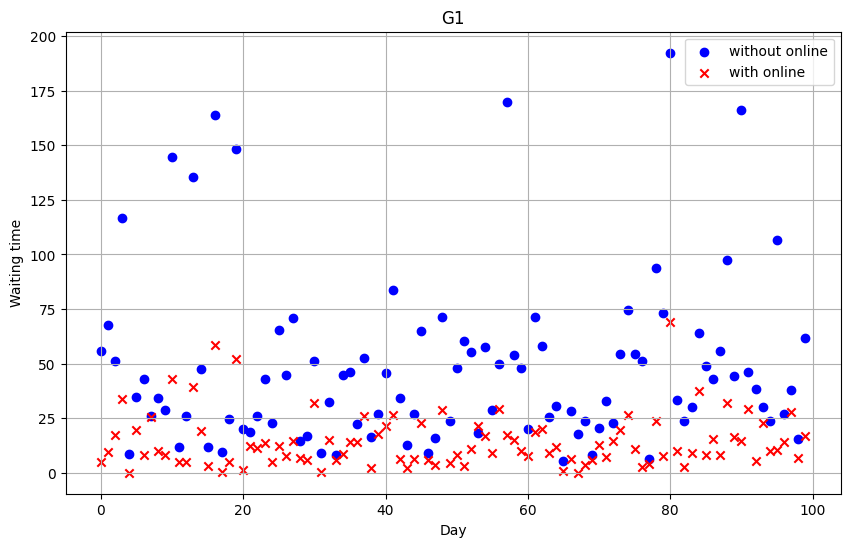

In [39]:
model_analysis('G1', 15, 3, 50, 0.3)

G2:

The average waiting time for primitive model of G2 is: 22.352296867503863
The average waiting time for modified model of G2 is: 7.946632186135682


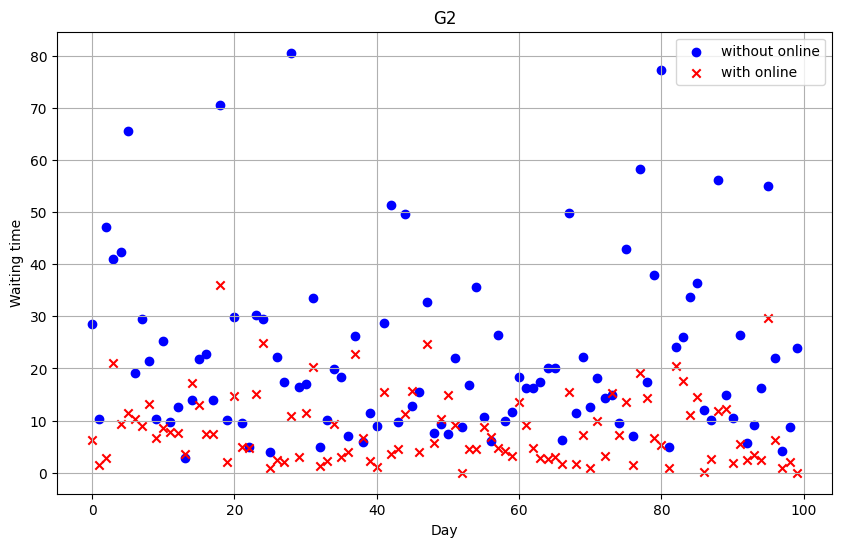

In [40]:
model_analysis('G2', 20, 3, 50, 0.3)

G3:

The average waiting time for primitive model of G3 is: 5.606075452315474
The average waiting time for modified model of G3 is: 2.8768323913529397


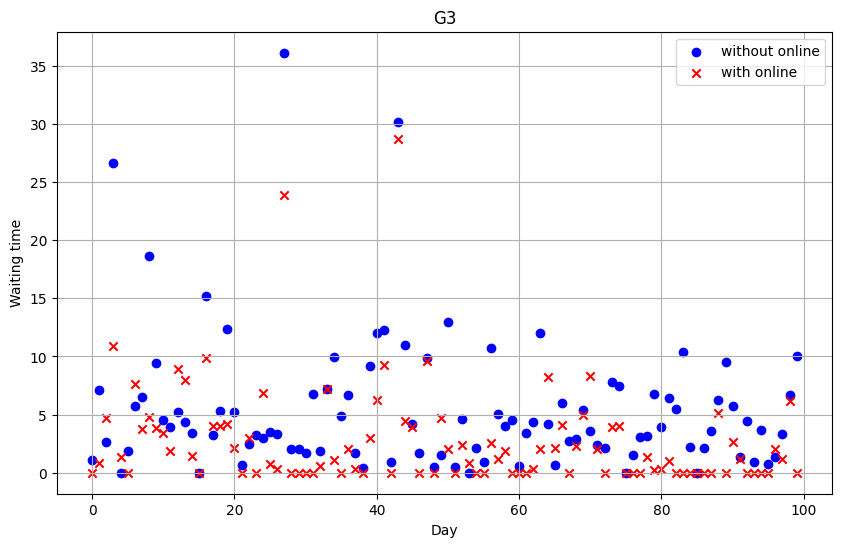

In [42]:
model_analysis('G3', 40, 3, 50, 0.3)

G4:

The average waiting time for primitive model of G3 is: 156.284104409832
The average waiting time for modified model of G3 is: 100.69099649217037


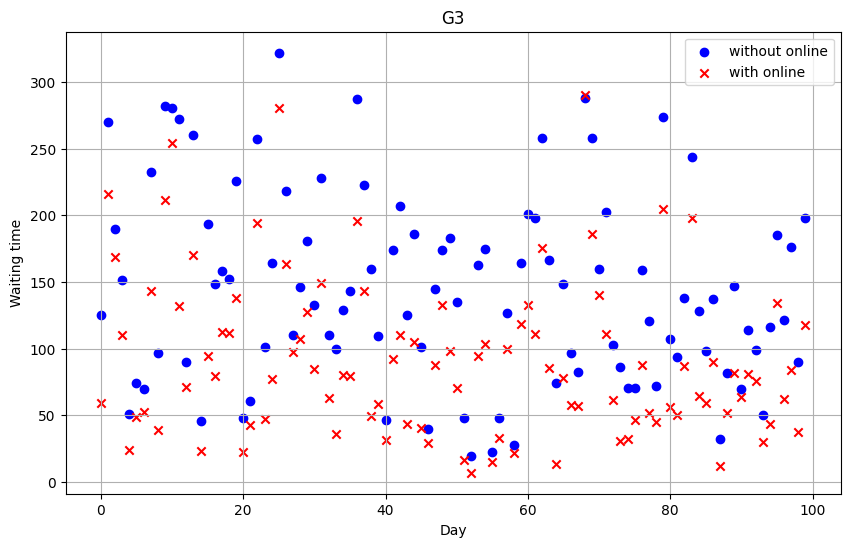

In [43]:
model_analysis('G3', 15, 8, 50, 0.3)

G5:

The average waiting time for primitive model of G5 is: 78.09849872909375
The average waiting time for modified model of G5 is: 48.762990243770524


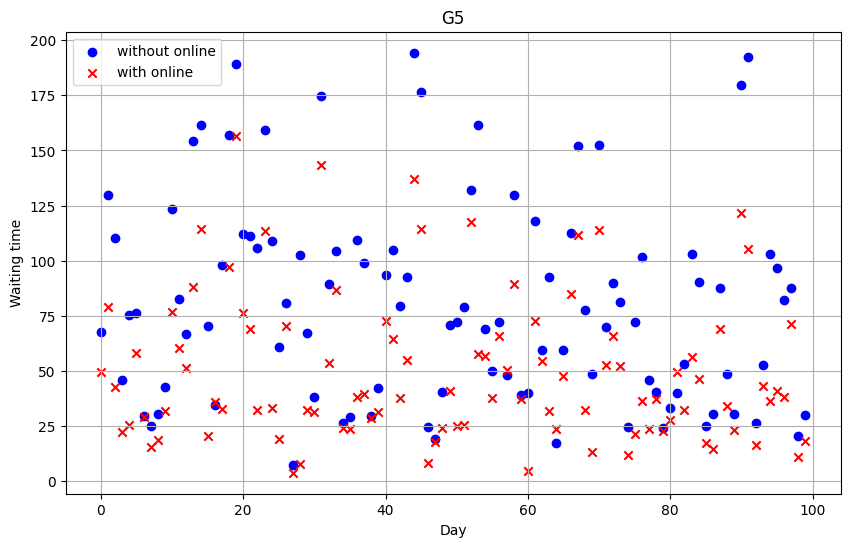

In [44]:
model_analysis('G5', 20, 8, 50, 0.3)

G6:

The average waiting time for primitive model of G6 is: 14.76858510570674
The average waiting time for modified model of G6 is: 10.727253969282575


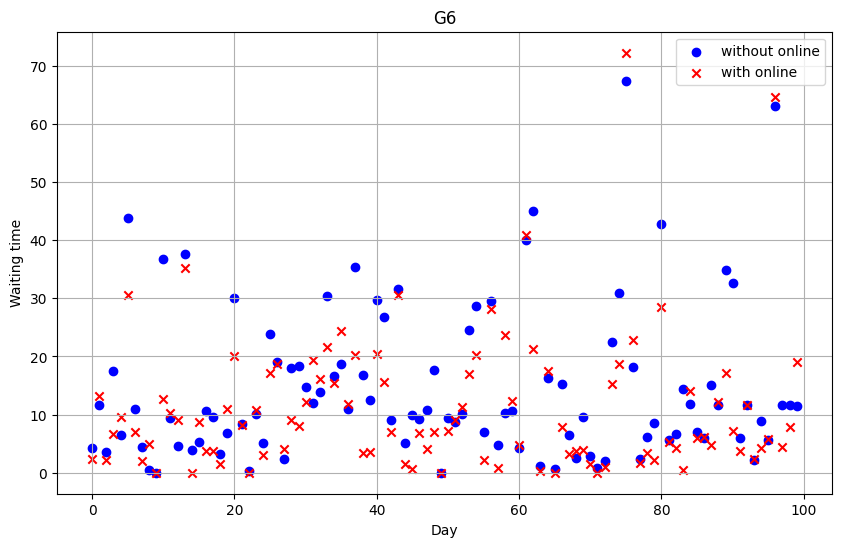

In [45]:
model_analysis('G6', 40, 8, 50, 0.3)

G7:

The average waiting time for primitive model of G7 is: 379.1801828902312
The average waiting time for modified model of G7 is: 367.4842535746714


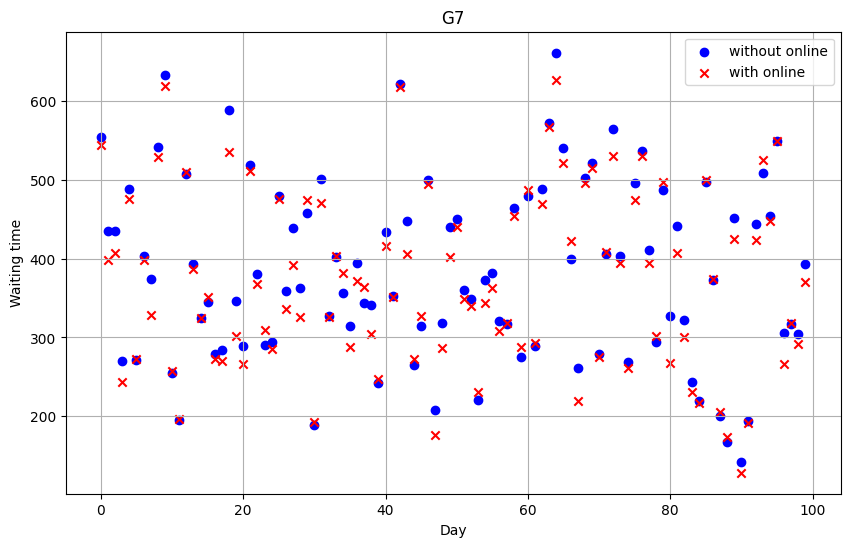

In [46]:
model_analysis('G7', 15, 15, 50, 0.3)

G8:

The average waiting time for primitive model of G5 is: 225.7838897126476
The average waiting time for modified model of G5 is: 217.4072433768703


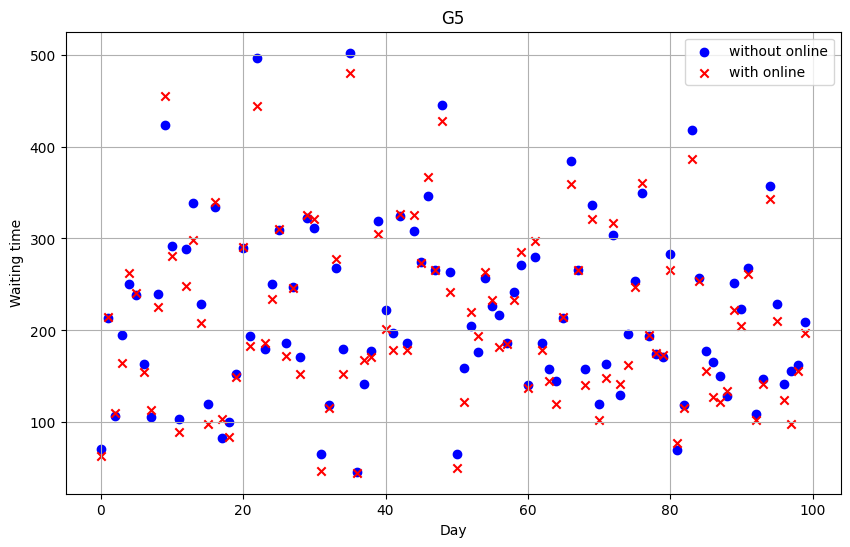

In [47]:
model_analysis('G8', 20, 15, 50, 0.3)

G9: 

The average waiting time for primitive model of G9 is: 13.521647426601747
The average waiting time for modified model of G9 is: 9.956768861678208


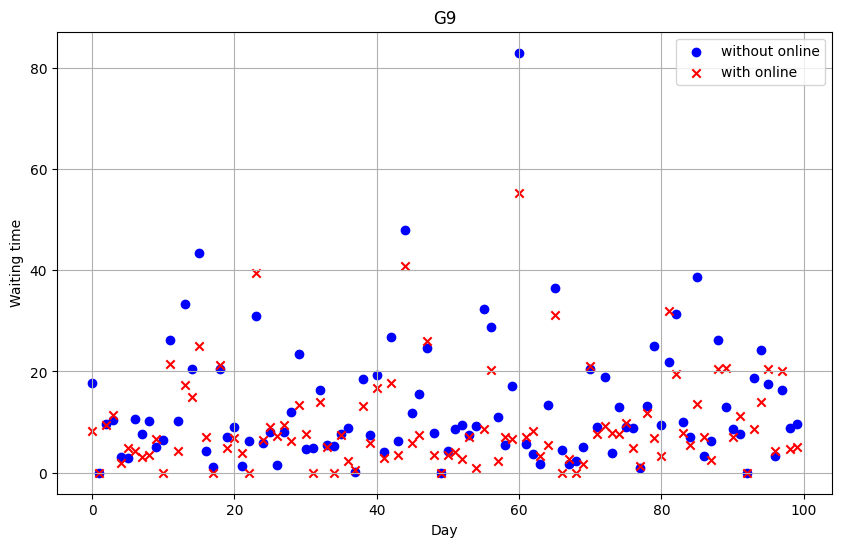

In [48]:
model_analysis('G9', 40, 8, 50, 0.3)

Then we fill all the blanks in the table: 

a) primitive model(without online)
|level of busyness/level of depression   | busy | normal      | idle|
|-------------|-------------|-------------|-------------|
| minimal depression | 47|22|6|
|  mild depression  | 156|78|15|
|   severe depression  |379|226|14|

a) modified model(with online)
|level of busyness/level of depression   | busy | normal      | idle|
|-------------|-------------|-------------|-------------|
| minimal depression | 14|8|3|
|  mild depression  | 101|49|11|
|   severe depression  |367|217|10|


## Step 06: Model Analysis 2

Now we will more precisely illustrate the model’s sensitivity to various parameters by plotting some graphs, following this approach:

The function `simulate_365_days` essentially defines a mapping from  $\mathbb{R}^5$  to  $\mathbb{R}$ . Here, we will plot the mapping relationship between two key parameters,  `mu` (representing the depression level) and `mean` (representing the busyness level), and the final outcome, which is the average waiting time.

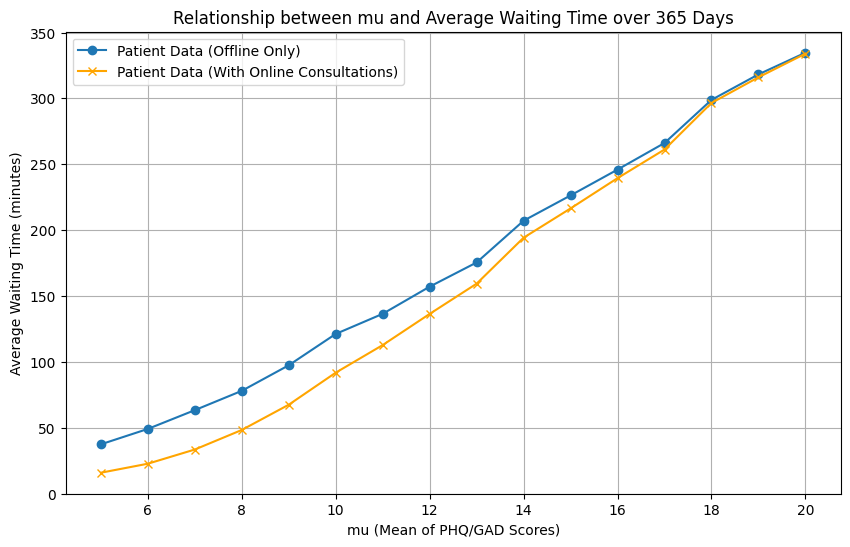

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Function to run the simulation for 365 days and return the average waiting time for each mu
def simulate_365_days_for_mu(mean, mu, var, conversion_rate, days=365):
    patient_data_waiting_times = []
    offline_patient_data_waiting_times = []

    for _ in range(days):
        # Generate patient data for a day
        patient_data = generate_a_data_matrix(mean=mean, mu=mu, var=var)
        offline_patient_data = convert_to_offline_patient_data(patient_data, conversion_rate)
        
        # Calculate the average waiting time for both patient data
        avg_waiting_time_patient_data = model_to_calculate_average_waiting_time(patient_data)
        avg_waiting_time_offline_patient_data = model_to_calculate_average_waiting_time(offline_patient_data)
        
        # Store the day's average waiting times
        patient_data_waiting_times.append(avg_waiting_time_patient_data)
        offline_patient_data_waiting_times.append(avg_waiting_time_offline_patient_data)
    
    # Calculate the average of the 365 days' waiting times
    overall_avg_waiting_time_patient = np.mean(patient_data_waiting_times)
    overall_avg_waiting_time_offline = np.mean(offline_patient_data_waiting_times)
    
    return overall_avg_waiting_time_patient, overall_avg_waiting_time_offline

# Initialize lists to store mu values and corresponding waiting times
mu_values = range(5, 21)  # For example, mu values from 5 to 20
waiting_times_patient_data = []
waiting_times_offline_patient_data = []

# Loop over different values of mu
for mu in mu_values:
    # Simulate 365 days for each mu value
    avg_waiting_time_patient_data, avg_waiting_time_offline_patient_data = simulate_365_days_for_mu(mean=20, mu=mu, var=50, conversion_rate=0.2)
    
    # Store the results
    waiting_times_patient_data.append(avg_waiting_time_patient_data)
    waiting_times_offline_patient_data.append(avg_waiting_time_offline_patient_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot for patient_data (completely offline)
plt.plot(mu_values, waiting_times_patient_data, marker='o', label='Patient Data (Offline Only)')

# Plot for offline_patient_data (with online consultations)
plt.plot(mu_values, waiting_times_offline_patient_data, marker='x', label='Patient Data (With Online Consultations)', color='orange')

# Add title and labels
plt.title('Relationship between mu and Average Waiting Time over 365 Days')
plt.xlabel('mu (Mean of PHQ/GAD Scores)')
plt.ylabel('Average Waiting Time (minutes)')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

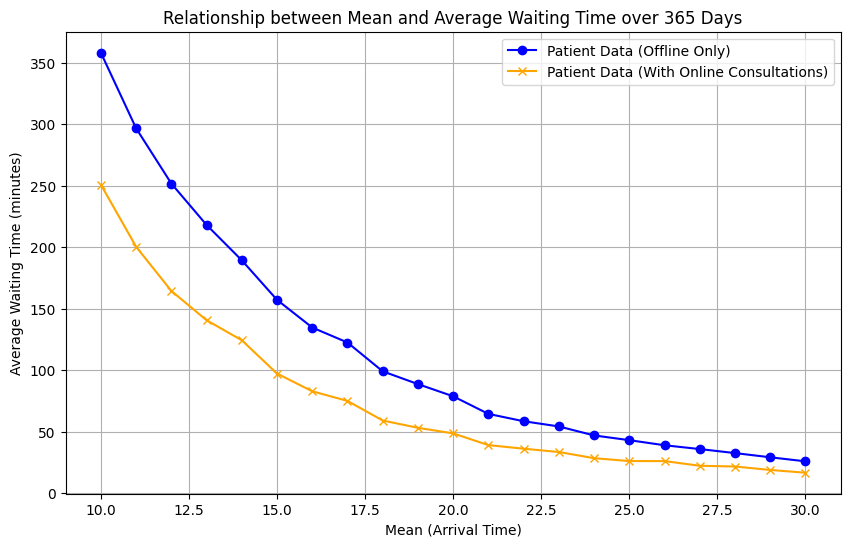

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store mean values and corresponding waiting times
mean_values = range(10, 31)  # For example, mean values from 10 to 30
waiting_times_patient_data = []
waiting_times_offline_patient_data = []

# Function to run the simulation for 365 days and return the average waiting time
def simulate_365_days(mean, mu, var, conversion_rate, days=365):
    # Lists to store average waiting times for each day
    patient_data_waiting_times = []
    offline_patient_data_waiting_times = []
    
    for _ in range(days):
        # Generate patient data for a day
        patient_data = generate_a_data_matrix(mean=mean, mu=mu, var=var)
        offline_patient_data = convert_to_offline_patient_data(patient_data, conversion_rate)
        
        # Calculate the average waiting time for both patient data
        avg_waiting_time_patient_data = model_to_calculate_average_waiting_time(patient_data)
        avg_waiting_time_offline_patient_data = model_to_calculate_average_waiting_time(offline_patient_data)
        
        # Store the day's average waiting times
        patient_data_waiting_times.append(avg_waiting_time_patient_data)
        offline_patient_data_waiting_times.append(avg_waiting_time_offline_patient_data)
    
    # Calculate the average of the 365 days' waiting times
    overall_avg_waiting_time_patient = np.mean(patient_data_waiting_times)
    overall_avg_waiting_time_offline = np.mean(offline_patient_data_waiting_times)
    
    return overall_avg_waiting_time_patient, overall_avg_waiting_time_offline

# Loop over different values of mean
for mean in mean_values:
    # Simulate 365 days for each mean value and get the average waiting times
    avg_waiting_time_patient_data, avg_waiting_time_offline_patient_data = simulate_365_days(mean=mean, mu=8, var=50, conversion_rate=0.2)
    
    # Store the results
    waiting_times_patient_data.append(avg_waiting_time_patient_data)
    waiting_times_offline_patient_data.append(avg_waiting_time_offline_patient_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot for patient data (completely offline)
plt.plot(mean_values, waiting_times_patient_data, marker='o', label='Patient Data (Offline Only)', color='blue')

# Plot for offline_patient_data (with online consultations)
plt.plot(mean_values, waiting_times_offline_patient_data, marker='x', label='Patient Data (With Online Consultations)', color='orange')

plt.title('Relationship between Mean and Average Waiting Time over 365 Days')
plt.xlabel('Mean (Arrival Time)')
plt.ylabel('Average Waiting Time (minutes)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
